In [1]:
import pandas as pd
import csv
import sqlite3
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [2]:
#My initial dataset was 123MB and a file that big can not be pushed to github. I had to create a selection specifically stats
#for the US and read them into a separate file for inclusion on Github. The commented out code below is the code I used
#to create my new file

#energy = pd.read_csv('all_energy_statistics.csv')

#energy.dropna()

#US_energy = energy['country_or_area'] == 'United States'

#test = energy[US_energy]

#test.to_csv(r'US_energy.csv', index = False)

USA_energy = pd.read_csv('US_energy.csv')

USA_energy.head(3)

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,United States,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",2484.0,NaN,additives_and_oxygenates
1,United States,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",2640.0,NaN,additives_and_oxygenates
2,United States,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",2579.0,NaN,additives_and_oxygenates


In [3]:
db = sqlite3.connect("Energy.db")

USA_energy.to_sql("Energy", db, if_exists="replace")

wind_query = 'SELECT * FROM Energy WHERE category="wind_electricity";'

wind_results = pd.read_sql_query(wind_query, db)

tot_query = 'SELECT * FROM Energy WHERE commodity_transaction="Electricity - net production";'

tot_results = pd.read_sql_query(tot_query, db)

wind_results['wind_as_per'] = wind_results['quantity'] / tot_results['quantity'] * 100
                               
wind_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,wind_as_per
0,19822,United States,Electricity - total wind production,2014,"Kilowatt-hours, million",183892.0,None,wind_electricity,4.460809
1,19823,United States,Electricity - total wind production,2013,"Kilowatt-hours, million",169713.0,None,wind_electricity,4.146015
2,19824,United States,Electricity - total wind production,2012,"Kilowatt-hours, million",141922.0,None,wind_electricity,3.480911


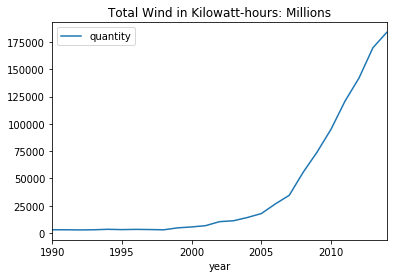

In [4]:
wind_results.plot(x='year', y='quantity', title='Total Wind in Kilowatt-hours: Millions')

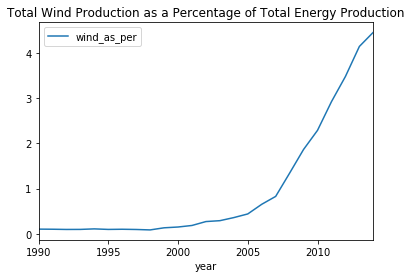

In [5]:
wind_results.plot(x='year', y='wind_as_per', title='Total Wind Production as a Percentage of Total Energy Production')

In [28]:
wind = px.bar(wind_results, x='year', y='quantity', labels={'quantity':'Kilowatt-Hours in Millions', 'year':'Year', 
              'wind_as_per':'Percentage of Wind vs Total'}, hover_data=['wind_as_per'], color='wind_as_per')

wind.show()

In [7]:
sol_query = 'SELECT * FROM Energy WHERE category="solar_electricity";'

sol_results = pd.read_sql_query(sol_query, db)

sol_results['sol_as_per'] = sol_results['quantity'] / tot_results['quantity'] * 100

sol_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,sol_as_per
0,17359,United States,Electricity - total solar production,2014,"Kilowatt-hours, million",24603.0,None,solar_electricity,0.596814
1,17360,United States,Electricity - total solar production,2013,"Kilowatt-hours, million",15872.0,None,solar_electricity,0.387746
2,17361,United States,Electricity - total solar production,2012,"Kilowatt-hours, million",10145.0,None,solar_electricity,0.248826


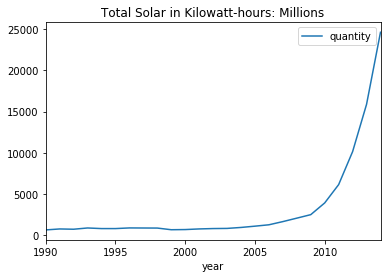

In [8]:
sol_results.plot(x='year', y='quantity', title='Total Solar in Kilowatt-hours: Millions')

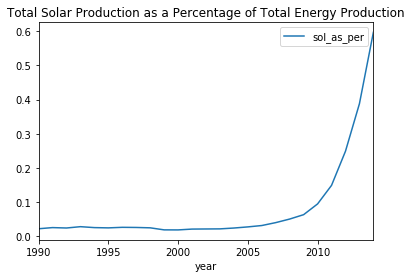

In [9]:
sol_results.plot(x='year', y='sol_as_per', title='Total Solar Production as a Percentage of Total Energy Production')

In [29]:
solar = px.bar(sol_results, x='year', y='quantity', labels={'quantity':'Kilowatt-Hours in Millions', 'year':'Year', 
               'sol_as_per':'Percentage of Solar vs Total'}, hover_data=['sol_as_per'], color='sol_as_per')

solar.show()

In [11]:
hyd_query = 'SELECT * FROM Energy WHERE category="hydro";'

hyd_results = pd.read_sql_query(hyd_query, db)

hyd_results['hyd_as_per'] = hyd_results['quantity'] / tot_results['quantity'] * 100

hyd_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,hyd_as_per
0,9058,United States,Electricity - total hydro production,2014,"Kilowatt-hours, million",281527.0,None,hydro,6.829216
1,9059,United States,Electricity - total hydro production,2013,"Kilowatt-hours, million",290113.0,None,hydro,7.087334
2,9060,United States,Electricity - total hydro production,2012,"Kilowatt-hours, million",298287.0,None,hydro,7.316065


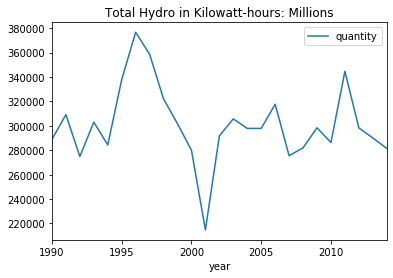

In [12]:
hyd_results.plot(x='year', y='quantity', title='Total Hydro in Kilowatt-hours: Millions')

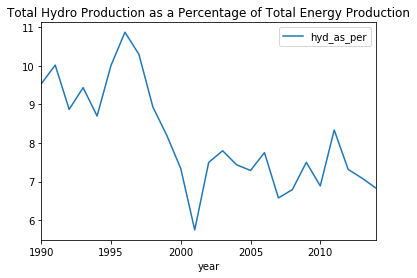

In [13]:
hyd_results.plot(x='year', y='hyd_as_per', title='Total Hydro Production as a Percentage of Total Energy Production')

In [30]:
hydro = px.bar(hyd_results, x='year', y='quantity', labels={'quantity':'Kilowatt-Hours in Millions', 'year':'Year', 
               'hyd_as_per':'Percentage of Hydro vs Total'}, hover_data=['hyd_as_per'], color='hyd_as_per')

hydro.show()

In [15]:
geo_query = 'SELECT * FROM Energy WHERE category="geothermal";'

geo_results = pd.read_sql_query(geo_query, db)

geo_results['geo_as_per'] = geo_results['quantity'] / tot_results['quantity'] * 100

geo_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,geo_as_per
0,7523,United States,Electricity - total geothermal production,2014,"Kilowatt-hours, million",18710.0,None,geothermal,0.453863
1,7524,United States,Electricity - total geothermal production,2013,"Kilowatt-hours, million",18422.0,None,geothermal,0.450041
2,7525,United States,Electricity - total geothermal production,2012,"Kilowatt-hours, million",18135.0,None,geothermal,0.444796


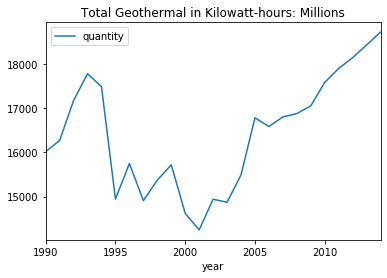

In [16]:
geo_results.plot(x='year', y='quantity', title='Total Geothermal in Kilowatt-hours: Millions')

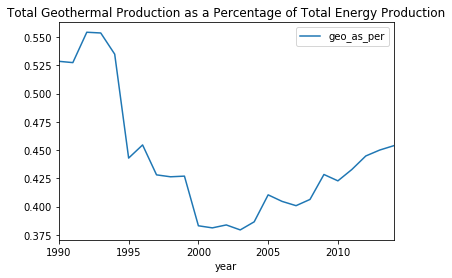

In [17]:
geo_results.plot(x='year', y='geo_as_per', title='Total Geothermal Production as a Percentage of Total Energy Production')

In [31]:
geothermal = px.bar(geo_results, x='year', y='quantity', labels={'quantity':'Kilowatt-Hours in Millions', 'year':'Year', 
                    'geo_as_per':'Percentage of Geothermal vs Total'}, hover_data=['geo_as_per'], color='geo_as_per')

geothermal.show()

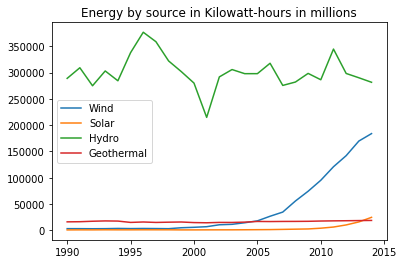

In [19]:
plt.subplots()

plt.plot(wind_results['year'], wind_results['quantity'])

plt.plot(sol_results['year'], sol_results['quantity'])

plt.plot(hyd_results['year'], hyd_results['quantity'])

plt.plot(geo_results['year'], geo_results['quantity'])

plt.title("Energy by source in Kilowatt-hours in millions")

plt.legend(['Wind', 'Solar', 'Hydro', 'Geothermal'])

In [20]:
renew=[wind_results['quantity'], sol_results['quantity'], hyd_results['quantity'], geo_results['quantity']]

fig = go.Figure(data=[
    go.Bar(name='Wind', x=wind_results['year'], y=wind_results['quantity']),
    go.Bar(name='Solar', x=sol_results['year'], y=sol_results['quantity']),
    go.Bar(name='Hydro', x=hyd_results['year'], y=hyd_results['quantity']),
    go.Bar(name='Geothermal', x=geo_results['year'], y=geo_results['quantity'])
])

# Change the bar mode
fig.update_layout(barmode='group')

fig.show()

In [21]:
tot_results['ren_as_per'] = (wind_results['quantity'] + sol_results['quantity'] + hyd_results['quantity'] + geo_results['quantity']) / tot_results['quantity'] * 100

tot_results.head(3)

,index,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category,ren_as_per
0,18732,United States,Electricity - net production,2014,"Kilowatt-hours, million",4122391.0,None,total_electricity,12.340702
1,18733,United States,Electricity - net production,2013,"Kilowatt-hours, million",4093401.0,None,total_electricity,12.071136
2,18734,United States,Electricity - net production,2012,"Kilowatt-hours, million",4077151.0,None,total_electricity,11.490597


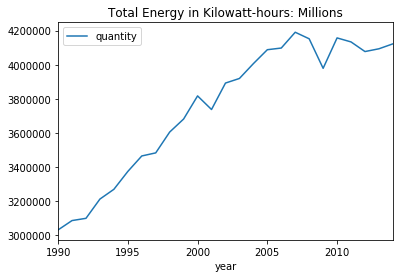

In [22]:
tot_results.plot(x='year', y='quantity', title='Total Energy in Kilowatt-hours: Millions')

In [33]:
total = px.bar(tot_results, x='year', y='quantity', labels={'quantity':'Kilowatt-Hours in Millions', 'year':'Year', 
               'ren_as_per':'Percentage of Renewables vs Total'}, hover_data=['ren_as_per'], color='ren_as_per')

total.show()

In [24]:
distinct = 'SELECT category, COUNT(*) AS NUMBER_OF_ENTRIES FROM Energy GROUP BY category;'

dis_show = pd.read_sql_query(distinct, db)

with pd.option_context('display.max_rows', 1104):
    display(dis_show)

,category,NUMBER_OF_ENTRIES
0,additives_and_oxygenates,168
1,animal_waste,269
2,anthracite,287
3,aviation_gasoline,247
4,bagasse,150
5,biodiesel,193
6,biogases,350
7,biogasoline,210
8,bitumen,256
9,black_liquor,168
